Song, Shim, Rosenberg (2022) Large-scale neural dynamics in a shared low-dimensional state space reflect cognitive and attentional dynamics<br>
code created by: Hayoung Song (hyssong@uchicago.edu), March 27, 2022

The code generates **Figure 5** of the paper

In [1]:
import numpy as np
import scipy.io
import random
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
random.seed(12345)

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
loaddir='../'
nsubj = 27
xlim1 = -2
xlim2 = 20
nevent = 12  # number of events for both sitcom episodes: 13
nstate = 4
niter = 1000 # permutation iteration
condition = ['sitcomep1','sitcomep2']
statename = ['DMN','DAN','SM','base']

In [3]:
# aligns latent state sequence at narrative event boundaries and computes the probability of occurrence per each state
def statealign2eb(hmm, eb, nstate, nsubj, nevent, xlim1, xlim2):
    # (input)
    # hmm: (subj*time) latent state sequence
    # eb: (time,) event boundary index; new event onset indicated as 1, others all 0
    
    # (output)
    # hmmalign: (subj*(time from xlim1 to xlim2))
    hmmaligned = []
    for subj in range(nsubj): # iterate over HMM-decoded latent sequences of all participants
        if np.all(np.isnan(hmm[subj,:])):
            pass
        else:
            aligned = np.zeros((nevent,xlim2-xlim1+1))
            ebi = -1
            for t in range(xlim1*(-1),len(eb)-xlim2):
                if eb[t]==1: # if time t is a new state onset
                    ebi=ebi+1
                    aligned_state = hmm[subj,t+xlim1:t+xlim2+1] # align time t to event boundary
                    for ii in range(len(aligned_state)):
                        if aligned_state[ii]==stt:
                            aligned[ebi,ii] = 1   # if a certain state occurred, mark 1 otherwise 0
            # mean across event boundaries: mean proportion of latent state occurrence
            hmmaligned.append(np.mean(aligned,0))
    return np.array(hmmaligned)

## Latent state occurrence aligned to narrative event boundaries (Figure 5a)

sitcomep1


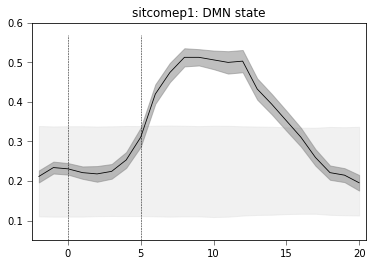

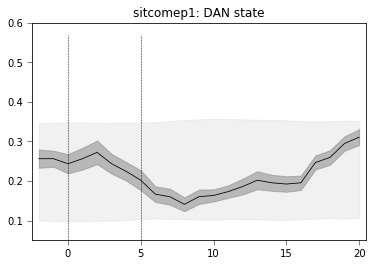

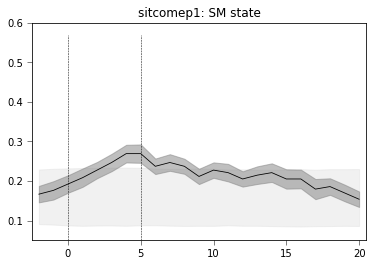

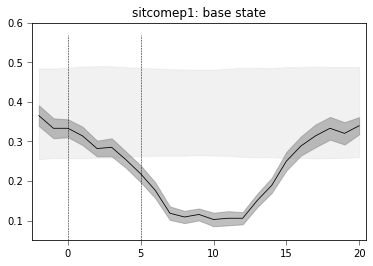

sitcomep2


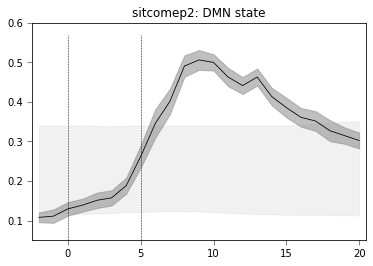

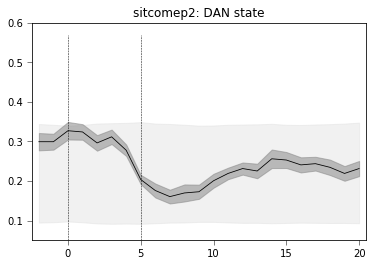

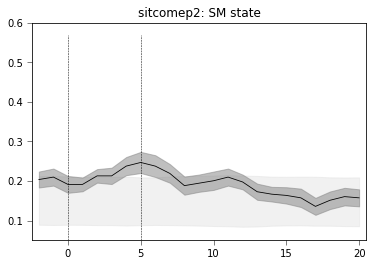

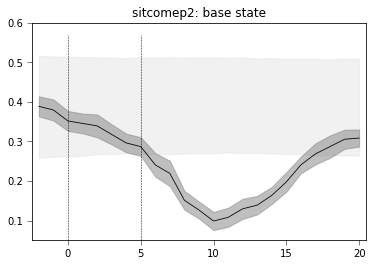

In [4]:
for cdti, cdt in enumerate(condition):
    print(cdt)
    # Mark event boundaries
    event = scipy.io.loadmat(loaddir+'behavior/'+cdt+'_beh.mat')['event'][:,0]
    eb = np.zeros((event.shape[0],))
    for t in range(1, event.shape[0]):
        if event[t-1]!=event[t]: # if transitions to a different event, index 1
            eb[t] = 1

    # Load HMM latent state sequence
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]

    for stt in range(1,nstate+1):
        # Per latent state, probability of state occurrence centered around event boundaries 
        # (subj*(time from xlim1 to xlim2))
        hmmaligned = statealign2eb(seq, eb, nstate, nsubj, nevent, xlim1, xlim2)
        
        # Create chance distribution
        hmmaligned_null = []
        for null in range(niter):
            # circular shift event index
            eb_null = np.roll(eb, np.random.randint(eb.shape[0]-20)+10)
            align_null = statealign2eb(seq, eb_null, nstate, nsubj, nevent, xlim1, xlim2)
            hmmaligned_null.append(np.mean(align_null,0))
        hmmaligned_null = np.array(hmmaligned_null)

        plt.figure(stt+cdti*nstate)
        plt.fill_between(np.arange(xlim1,xlim2+1), np.mean(hmmaligned_null,0)-1.96*np.std(hmmaligned_null,0),
                         np.mean(hmmaligned_null,0)+1.96*np.std(hmmaligned_null,0),
                         color='lightgray',alpha=0.3)
        plt.fill_between(np.arange(xlim1,xlim2+1), np.mean(hmmaligned,0)-np.std(hmmaligned,0)/np.sqrt(hmmaligned.shape[0]),
                         np.mean(hmmaligned,0)+np.std(hmmaligned,0)/np.sqrt(hmmaligned.shape[0]),
                         color='gray',alpha=0.5)
        plt.plot(np.arange(xlim1,xlim2+1),np.mean(hmmaligned,0), c='k',linewidth=0.8)
        plt.ylim([0.05,0.6])
        plt.xlim([xlim1-0.5,xlim2+0.5])
        plt.xticks([0,5,10,15,20])
        plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6])
        plt.vlines(0,0.05,0.57,colors='k',linestyles='--',linewidths=0.5)
        plt.vlines(5,0.05,0.57,colors='k',linestyles='--',linewidths=0.5)
        plt.tick_params(length=5, width=0.5)
        plt.title(cdt+': '+statename[stt-1]+' state')
        plt.show()

## Transitions to DMN state at event boundaries vs. non-event boundaries (Figure 5c)

In [5]:
dancmap = (57 / 255, 0 / 255, 216 / 255)
smcmap = (15 / 255, 157 / 255, 88 / 255)
basecmap = (255 / 255, 215 / 255, 0 / 255)
    
minval, maxval = 5,15
dmnstateid = 1

sitcomep1
to DMN state at event boundaries    : [0.239 0.316 0.446]
to DMN state at non-event boundaries: [0.202 0.177 0.62 ]


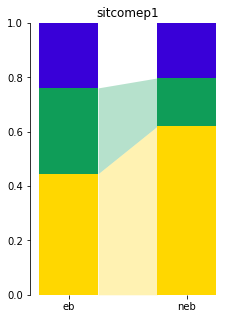

sitcomep2
to DMN state at event boundaries    : [0.284 0.275 0.441]
to DMN state at non-event boundaries: [0.191 0.187 0.622]


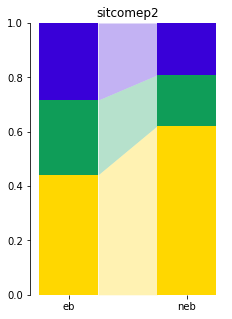

In [6]:
for cdt in condition:
    print(cdt)

    # Mark event boundaries
    event = scipy.io.loadmat(loaddir+'behavior/'+cdt+'_beh.mat')['event'][:,0]
    eb = np.zeros((event.shape[0],))
    for t in range(1, event.shape[0]):
        if event[t-1]!=event[t]: # if transitions to a different event, index 1
            eb[t] = 1

    # Load HMM latent state sequence
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]
    
    # Categorize to-DMN transitions to eb vs. noeb depending on whether it occurred 5-15s after the event boundaries or not
    dmn_eb, dmn_noeb = [], []
    for subj in range(nsubj):
        if np.all(np.isnan(seq[subj,:])):
            pass
        else:
            todmn_eb = np.zeros((nstate-1,))
            todmn_noeb = np.zeros((nstate-1,))
            for t in range(maxval,eb.shape[0]):
                # if transitions to DMN state
                if seq[subj,t-1]!=seq[subj,t] and seq[subj,t]==dmnstateid: 
                    # categorize this to eb vs. noeb depending on whether it occurs 5-15s after the event boundaries or not
                    if np.any(eb[t-maxval:t-minval+1]==1): # if event boundary occurred at t-15:t-5 before neural state transition at t
                        todmn_eb[int(seq[subj,t-1]-2)] = todmn_eb[int(seq[subj,t-1]-2)]+1 # column: (1) DAN, (2) SM, (3) base
                    else:
                        todmn_noeb[int(seq[subj,t-1]-2)] = todmn_noeb[int(seq[subj,t-1]-2)]+1
            # change count to proportion
            dmn_eb.append(todmn_eb/np.sum(todmn_eb))
            dmn_noeb.append(todmn_noeb/np.sum(todmn_noeb))
    dmn_eb, dmn_noeb = np.array(dmn_eb), np.array(dmn_noeb)
    print('to DMN state at event boundaries    : '+str(np.round(np.mean(dmn_eb,0),3)))
    print('to DMN state at non-event boundaries: '+str(np.round(np.mean(dmn_noeb,0),3)))
    
    # Paired Wilcoxon signed-rank test & FDR correction 
    pvals = []
    for stt in range(nstate-1):
        pvals.append(scipy.stats.wilcoxon(dmn_eb[:,stt], dmn_noeb[:,stt])[1])
    qvals = fdrcorrection(np.array(pvals))[1]

    # Figure (stacked bar plot with significance indicated with shade)
    dan = np.mean(dmn_eb,0)[0], np.mean(dmn_noeb,0)[0]
    sm = np.mean(dmn_eb,0)[1], np.mean(dmn_noeb,0)[1]
    base = np.mean(dmn_eb,0)[2], np.mean(dmn_noeb,0)[2]

    fig, ax1 = plt.subplots(1,1,figsize=(3.5,5))
    xtl = ['eb','neb']
    ax1.bar(xtl, base, width=0.5, label='base', color=basecmap, linewidth=0)
    ax1.bar(xtl, sm, width=0.5, bottom=base, label='sm', color=smcmap, linewidth=0)
    ax1.bar(xtl, dan, width=0.5, bottom=np.array(sm)+np.array(base), label='dan', color=dancmap, linewidth=0)
    if qvals[0]<0.05:
        ax1.fill_between(np.array([0.25,0.75]), np.array(sm)+np.array(base), np.array([1,1]), color=dancmap, alpha=0.3, linewidth=0)
    if qvals[1]<0.05:
        ax1.fill_between(np.array([0.25,0.75]), base, np.array(sm)+np.array(base), color=smcmap, alpha=0.3, linewidth=0)
    if qvals[2]<0.05:
        ax1.fill_between(np.array([0.25,0.75]), np.array([0,0]), base, color=basecmap, alpha=0.3, linewidth=0)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(True)
    ax1.set_ylim([0,1])
    ax1.set_title(cdt)
    plt.show()